# Install Packages

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install scikit-learn

DEPRECATION: neuralplot 0.0.8 has a non-standard dependency specifier matplotlib>=3.1numpy>=1.16. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of neuralplot or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: neuralplot 0.0.8 has a non-standard dependency specifier matplotlib>=3.1numpy>=1.16. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of neuralplot or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: neuralplot 0.0.8 has a non-standard dependency specifier matplotlib>=3.1numpy>=1.16. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of neuralplot or contact the author

# Import Libraries

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
color_pal = sns.color_palette()

# Data Pre-processing

In [3]:
file_path_temperature = 'sensor_data_vendor_data.csv'
df = pd.read_csv(file_path_temperature)

df_CO2 = df[['Time','CO2']].copy()

df_CO2['Time'] = pd.to_datetime(df_CO2['Time'])

df_CO2.rename(columns={'Time': 'dateTime'}, inplace=True)

df_CO2.set_index('dateTime', inplace=True)
df_CO2.index = pd.to_datetime(df_CO2.index)

df_CO2.dropna(inplace=True)

df_CO2['CO2'] = df_CO2['CO2'].str.extract('([0-9.]+)').astype(float)

print(df_CO2)

                       CO2
dateTime                  
2023-12-31 20:00:00  462.0
2023-12-31 14:00:00  451.0
2023-12-31 08:00:00  449.0
2023-12-31 02:00:00  458.0
2023-12-30 20:00:00  468.0
...                    ...
2023-09-10 14:00:00  501.0
2023-09-10 08:00:00  514.0
2023-09-10 02:00:00  560.0
2023-09-09 20:00:00  638.0
2023-09-09 14:00:00  723.0

[454 rows x 1 columns]


# Remove Outlier

In [4]:
mean_temp = df_CO2['CO2'].mean()
std_temp = df_CO2['CO2'].std()

df_CO2['Z_score'] = (df_CO2['CO2'] - mean_temp) / std_temp

# Remove the data points with Z-scores beyond +/- 3 standard deviations
df_CO2 = df_CO2[df_CO2['Z_score'].abs() <= 3]

df_CO2.drop('Z_score', axis=1, inplace=True)

df_CO2.shape

(442, 1)

# Visualize Dataset

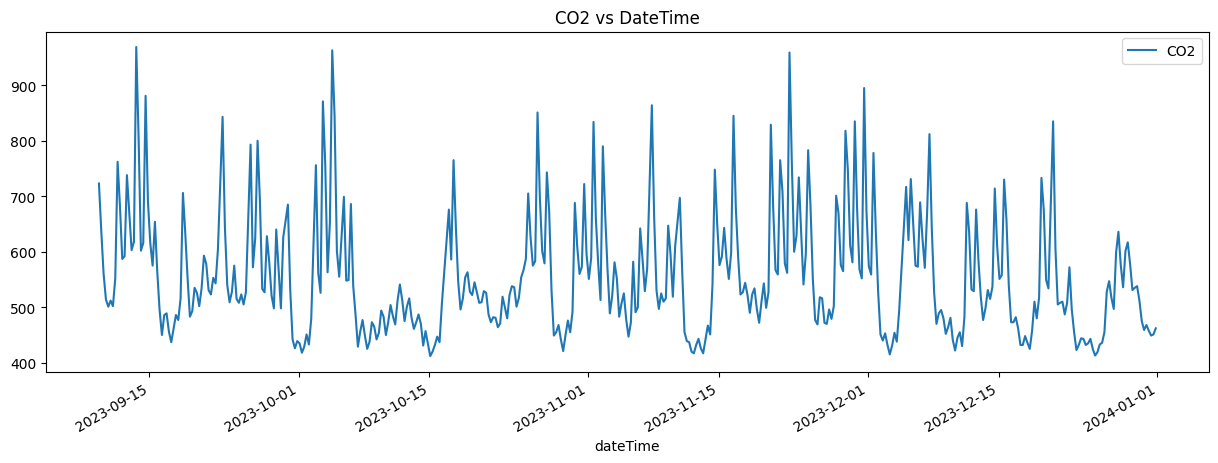

In [5]:
df_CO2.plot(figsize=(15, 5),
                    color=color_pal[0],
                    title='CO2 vs DateTime',
                    linestyle='-')  # Optional, '-' is the default for line plots
plt.show()


# Train / Test Split

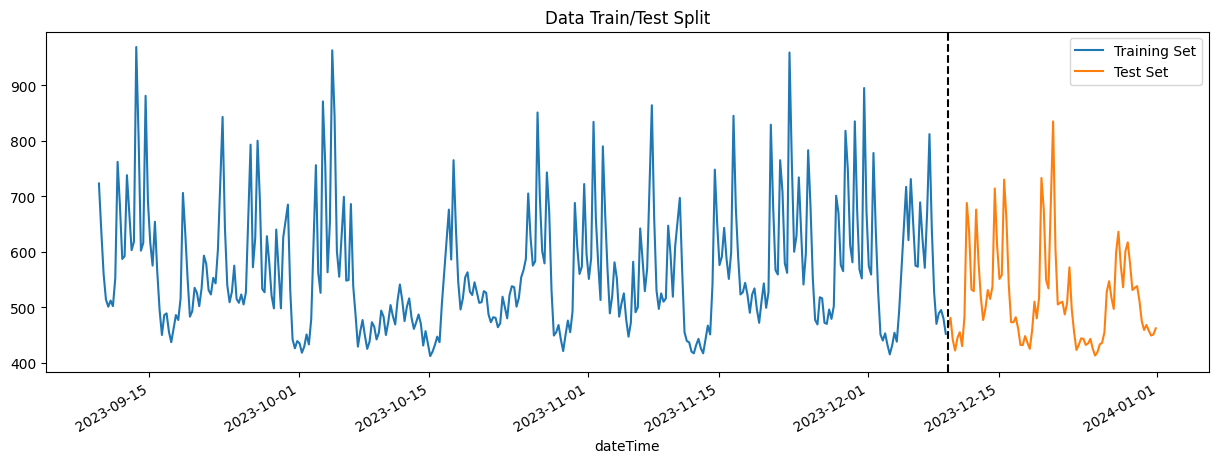

In [6]:
df_CO2 = df_CO2.sort_index()

split_point = int(len(df_CO2) * 0.8)

train = df_CO2.iloc[:split_point]
test = df_CO2.iloc[split_point:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

split_date = df_CO2.index[split_point]
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Creation

In [7]:
# Create time series features based on time series index.
def create_features(df_CO2):
    df_CO2 = df_CO2.copy()
    df_CO2['hour'] = df_CO2.index.hour
    df_CO2['dayofweek'] = df_CO2.index.dayofweek
    df_CO2['quarter'] = df_CO2.index.quarter
    df_CO2['month'] = df_CO2.index.month
    df_CO2['year'] = df_CO2.index.year
    df_CO2['dayofyear'] = df_CO2.index.dayofyear
    df_CO2['dayofmonth'] = df_CO2.index.day
    df_CO2['weekofyear'] = df_CO2.index.isocalendar().week
    return df_CO2

df_CO2 = create_features(df_CO2)
df_CO2

,CO2,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
dateTime,,,,,,,,,
2023-09-09 14:00:00,723.0,14,5,3,9,2023,252,9,36
2023-09-09 20:00:00,638.0,20,5,3,9,2023,252,9,36
2023-09-10 02:00:00,560.0,2,6,3,9,2023,253,10,36
2023-09-10 08:00:00,514.0,8,6,3,9,2023,253,10,36
2023-09-10 14:00:00,501.0,14,6,3,9,2023,253,10,36
...,...,...,...,...,...,...,...,...,...
2023-12-30 20:00:00,468.0,20,5,4,12,2023,364,30,52
2023-12-31 02:00:00,458.0,2,6,4,12,2023,365,31,52
2023-12-31 08:00:00,449.0,8,6,4,12,2023,365,31,52


# Visualize Feature and Target Relationship

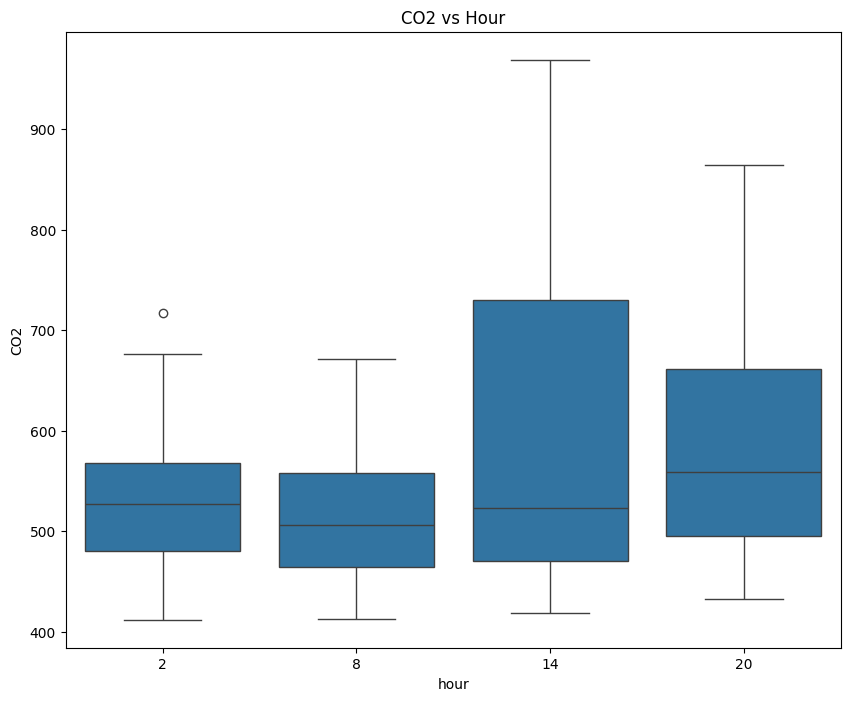

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_CO2, x='hour', y='CO2')
ax.set_title('CO2 vs Hour')
ax.set_ylabel('CO2')
plt.show()

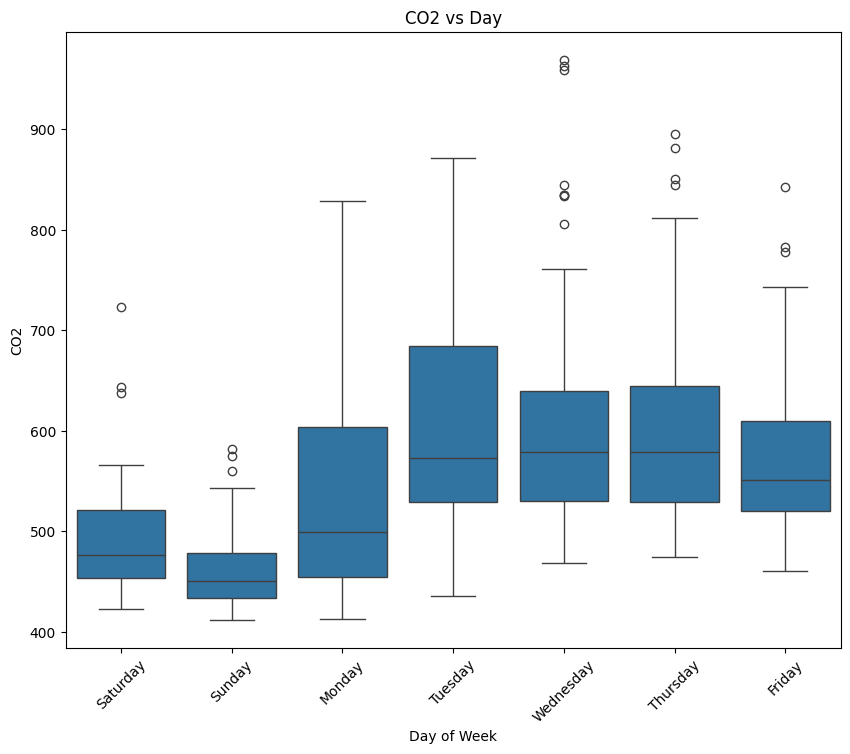

In [9]:
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df_CO2['dayofweek_name'] = df_CO2['dayofweek'].map(day_names)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_CO2, x='dayofweek_name', y='CO2')
ax.set_title('CO2 vs Day')
ax.set_xlabel('Day of Week') 
ax.set_ylabel('CO2')
plt.xticks(rotation=45)
plt.show()


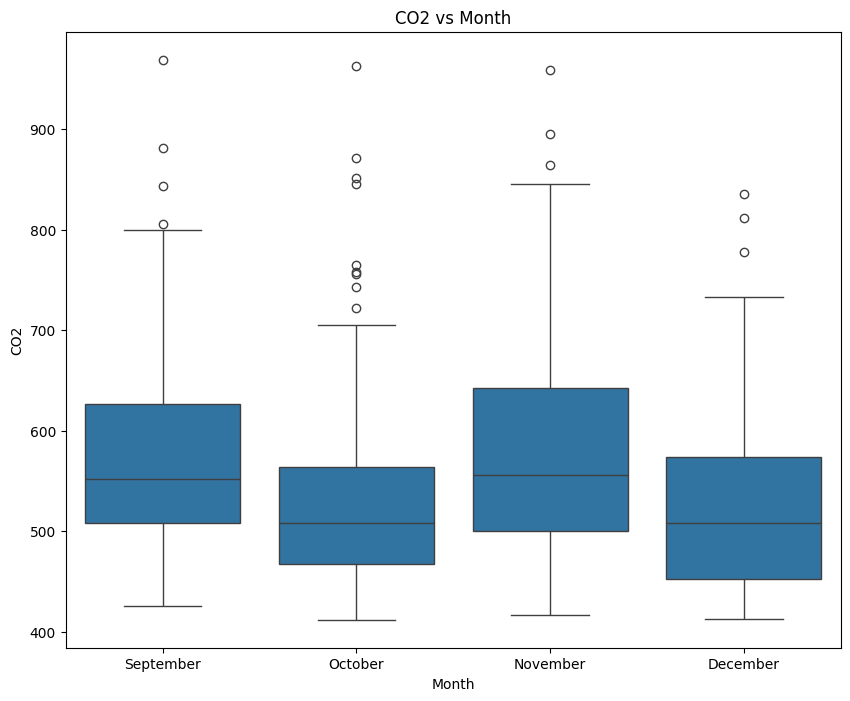

In [10]:
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_CO2, x='month', y='CO2')

ax.set_title('CO2 vs Month')
ax.set_ylabel('CO2')
ax.set_xlabel('Month')

unique_months = sorted(df_CO2['month'].unique())

ax.set_xticks(range(len(unique_months)))

ax.set_xticklabels([month_names[month] for month in unique_months])

plt.show()


# Create our Model

In [11]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'dayofyear', 'quarter', 'month', 'year']

TARGET = 'CO2'
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

print(X_train)
print(y_train)

                     hour  dayofweek  dayofyear  quarter  month  year
dateTime                                                             
2023-09-09 14:00:00    14          5        252        3      9  2023
2023-09-09 20:00:00    20          5        252        3      9  2023
2023-09-10 02:00:00     2          6        253        3      9  2023
2023-09-10 08:00:00     8          6        253        3      9  2023
2023-09-10 14:00:00    14          6        253        3      9  2023
...                   ...        ...        ...      ...    ...   ...
2023-12-08 08:00:00     8          4        342        4     12  2023
2023-12-08 14:00:00    14          4        342        4     12  2023
2023-12-08 20:00:00    20          4        342        4     12  2023
2023-12-09 02:00:00     2          5        343        4     12  2023
2023-12-09 08:00:00     8          5        343        4     12  2023

[353 rows x 6 columns]
dateTime
2023-09-09 14:00:00    723.0
2023-09-09 20:00:00    638.0

# Train Model

In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:568.42032	validation_1-rmse:516.63442
[100]	validation_0-rmse:223.39669	validation_1-rmse:187.78528
[200]	validation_0-rmse:107.30043	validation_1-rmse:74.65363
[300]	validation_0-rmse:74.42677	validation_1-rmse:65.28055
[331]	validation_0-rmse:70.54876	validation_1-rmse:66.73107


/common/home/projectgrps/IS460/IS460G6/jupyterlab-venv-py311/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:28:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

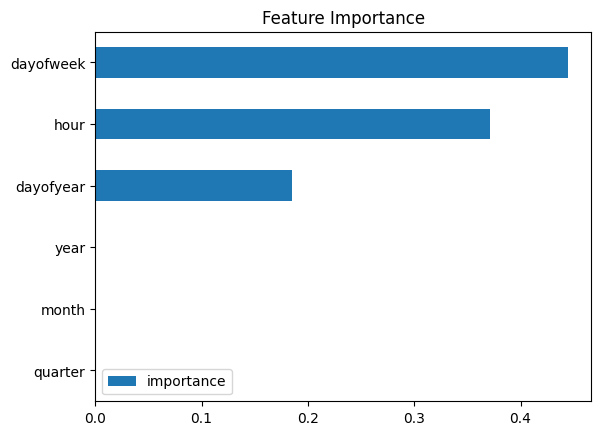

In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test Dataset

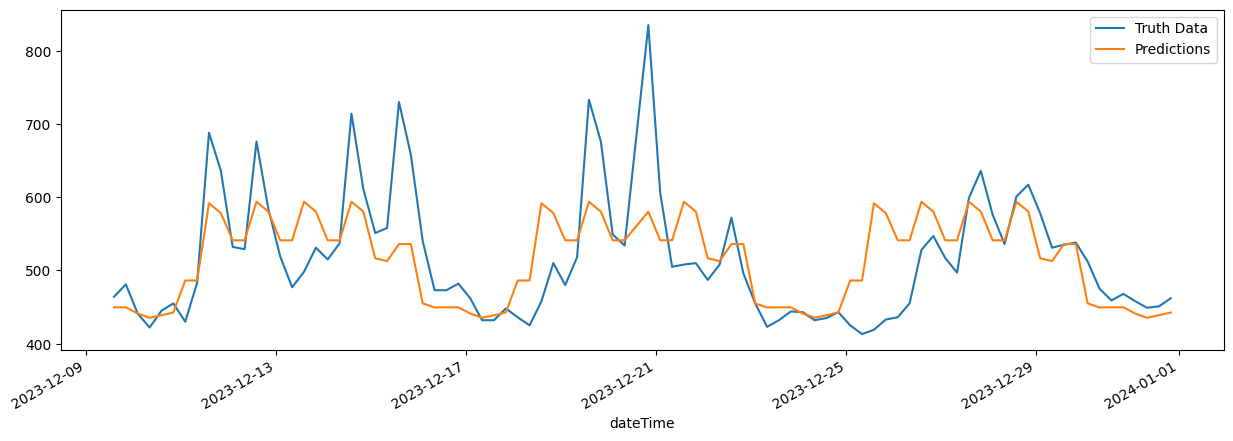

In [14]:
test['prediction'] = reg.predict(X_test)
test['CO2'].plot(figsize=(15, 5))
test['prediction'].plot(figsize=(15, 5))
plt.legend(['Truth Data', 'Predictions'])
plt.show()

# Score (RMSE)

In [15]:
# Calculate RMSE
rmse_score = np.sqrt(mean_squared_error(test['CO2'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')

# Calculate MAPE
mape_score = np.mean(np.abs((test['CO2'] - test['prediction']) / test['CO2'])) * 100
print(f'MAPE Score on Test set: {mape_score:0.2f}%')

# Calculate R-squared
r_squared_score = r2_score(test['CO2'], test['prediction'])
print(f'R-squared Score on Test set: {r_squared_score:0.2f}')

RMSE Score on Test set: 64.76
MAPE Score on Test set: 8.28%
R-squared Score on Test set: 0.41


# Calculate Error
- Look at the worst and best predicted days

In [16]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-12-25    113.131409
2023-12-15     98.946976
2023-12-20     89.892273
2023-12-19     79.757690
2023-12-18     78.381409
2023-12-26     72.572876
2023-12-21     64.282593
2023-12-13     57.822876
2023-12-11     53.366272
2023-12-14     45.257690
Name: error, dtype: float64

# Predicting the Future

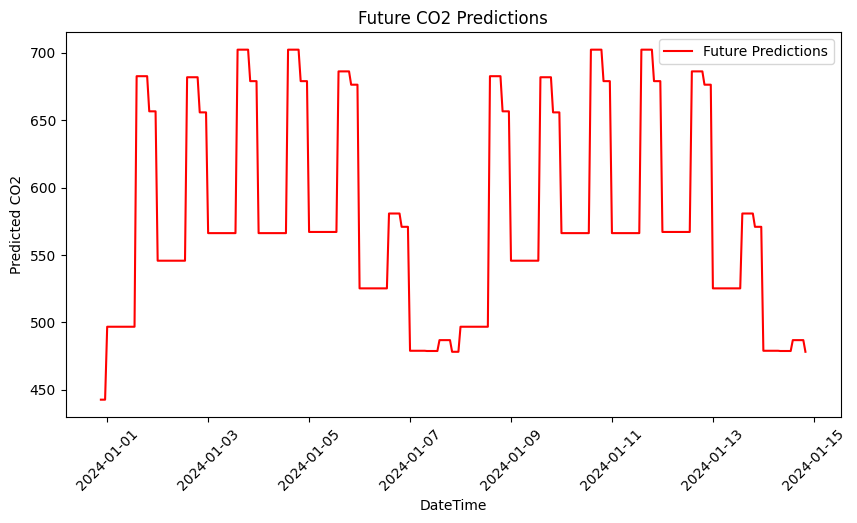

In [17]:
# Step 1: Generate Future Time Frame
# Define a start date for the future predictions and the number of periods/hours you want to predict
future_start_date = df_CO2.index.max() + pd.Timedelta(hours=1)
num_days = 14 # ADJUST THIS
num_hours = 0 # ADJUST THIS
num_future_periods = (num_days * 24) + num_hours  # For example, predicting the next 24 hours

# Generate future datetime index
future_dates = pd.date_range(start=future_start_date, periods=num_future_periods, freq='h')

# Create a DataFrame for the future time frame
future_df = pd.DataFrame(index=future_dates, columns=FEATURES)
future_df.index.name = 'dateTime'

# Step 2: Create Features for Future Time Frame
# Use the create_features function to generate features for the future_df
future_df = create_features(future_df)

# Step 3: Predict Future Values
# Make sure to select only the columns used as features
future_df['prediction'] = reg.predict(future_df[FEATURES])

# Visualize the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_df.index, future_df['prediction'], label='Future Predictions', color='red')
plt.title('Future CO2 Predictions')
plt.xlabel('DateTime')
plt.ylabel('Predicted CO2')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Note: This is a simplified approach and assumes the existence of features that can be generated 
# without having actual future values (e.g., time-based features). For features dependent on unknown future 
# conditions or values, you'd need to estimate or model those features differently.


# Saving Model

In [18]:
# Save model
reg.save_model('model_CO2_vendor.json')

In [19]:
!ls -lh

total 15M
-rw-rw-r--. 1 IS460G6 IS460G6  15K Mar 10 17:34 archieve.ipynb
-rw-rw-r--. 1 IS460G6 IS460G6  18K Mar  4 17:43 Draft1.ipynb
-rw-rw-r--. 1 IS460G6 IS460G6  468 Mar 15 17:16 future_temperature_predictions.csv
-rw-rw-r--. 1 IS460G6 IS460G6 424K Mar  4 17:41 lstm_model.h5
-rw-rw-r--. 1 IS460G6 IS460G6 2.3K Mar  4 17:18 lstm_model.py
-rw-rw-r--. 1 IS460G6 IS460G6  740 Mar  4 17:18 lstm_predict.py
-rw-rw-r--. 1 IS460G6 IS460G6 428K Mar 11 10:47 model_co2.json
-rw-rw-r--. 1 IS460G6 IS460G6 489K Mar 11 11:50 model_co2_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 300K Apr  1 21:28 model_CO2_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 246K Mar 11 10:47 model_humidity.json
-rw-rw-r--. 1 IS460G6 IS460G6 853K Mar 15 20:21 model_humidity_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 246K Mar 10 17:41 model.json
-rw-rw-r--. 1 IS460G6 IS460G6 346K Mar 11 10:47 model_temperature.json
-rw-rw-r--. 1 IS460G6 IS460G6 724K Apr  1 21:27 model_temperature_vendor.json
-rw-rw-r--. 1 IS460G6 IS460G6 3.9M Mar 10

# Using Model from Saved Model

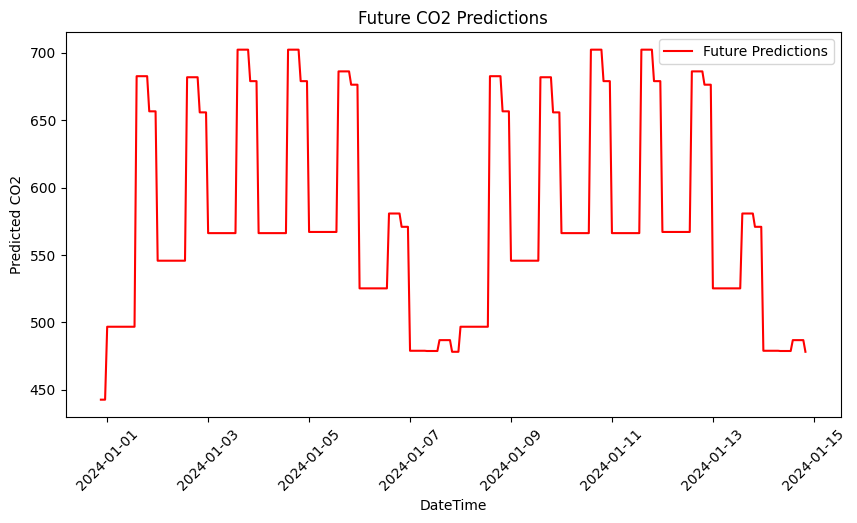

In [20]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model_CO2_vendor.json')

future_start_date = df_CO2.index.max() + pd.Timedelta(hours=1)
num_days = 14 # ADJUST THIS
num_hours = 0 # ADJUST THIS
num_future_periods = (num_days * 24) + num_hours  # For example, predicting the next 24 hours

# Generate future datetime index
future_dates = pd.date_range(start=future_start_date, periods=num_future_periods, freq='h')

# Create a DataFrame for the future time frame
future_df = pd.DataFrame(index=future_dates, columns=FEATURES)
future_df.index.name = 'dateTime'

# Step 2: Create Features for Future Time Frame
# Use the create_features function to generate features for the future_df
future_df = create_features(future_df)

# Step 3: Predict Future Values
# Make sure to select only the columns used as features
future_df['prediction'] = reg_new.predict(future_df[FEATURES])

# Visualize the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_df.index, future_df['prediction'], label='Future Predictions', color='red')
plt.title('Future CO2 Predictions')
plt.xlabel('DateTime')
plt.ylabel('Predicted CO2')
plt.xticks(rotation=45)
plt.legend()
plt.show()